# Image Classification - Multi-Layer Perceptron(MLP) - PyTorch

In this network we will train a MLP to classify images using PyTorch framework. We will be using a pretrained model and adding our classifer to it and use it in image classification.

Below are the steps at a higher level:
>1. Import the packages
2. Loading and preprocessing the data
3. Define the model
4. Train the model
5. Test the trained model


<img src="MLP_PyTorch.png" style="width:650px;height:400px;">
<caption><center> <u>MLP Outline</u></center></caption>

## 1. Import the packages

Make sure to install all the packages 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [torch](http://pytorch.org) is a library for Python programs that facilitates building deep learning projects.

To install from pip : 'pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html'<br>
To install from conda : 'conda install pytorch torchvision cudatoolkit=10.1 -c pytorch'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 2. Loading and preprocessing the data

First up, we need to get our dataset. 

In the variable data_dir, update it with your directory name. Place all your test and train images in a folder 'data_dir' and labels of every image as a folder. For eg: if you have a cats and dogs images, training data will be in 'data_dir/train/cats/' & 'data_dir/train/dogs/' and similarly for test it should be in 'data_dir/test/cats/' and 'data_dir/test/dogs/'. 

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

#TODO : change it to your directory
data_dir = 'Test_data'

Transforms are common image transformations.

- <b>transforms.RandomRotation(30):</b> This will rotate the image by an angle.
- <b>transforms.RandomResizedCrop(224):</b> This will extract a patch of size (224, 224) from your input image randomly. So, it might pick this path from topleft, bottomright or anywhere in between. So, you are doing data augmentation in this part. Also, changing this value won't play nice with the fully-connected layers in your model, so not advised to change this.
- <b>transforms.RandomHorizontalFlip():</b> Once we have our image of size (224, 224), we can choose to flip it. This is another part of data augmentation.
- <b>transforms.ToTensor():</b> This just converts your input image to PyTorch tensor.
- <b>transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):</b> This is just input data scaling and these values (mean and std) must have been precomputed for your dataset. All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

ImageFolder: A generic data loader where the images are arranged in this way

- root/dog/xxx.png
- root/dog/xxy.png
- root/dog/xxz.png

- root/cat/123.png
- root/cat/nsdf3.png
- root/cat/asd932_.png

In [4]:
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

Define the validation size and get the indices for the validation testing

In [5]:
# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

<b>Data loader</b> Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

In [6]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

## 3. Define the model

We will be using a pretrained model [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5) to classify the images. There are various other models which can be leveraged.Below are some of them.

- [AlexNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id1)
- [VGG](http://pytorch.org/docs/0.3.0/torchvision/models.html#id2)
- [ResNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id3)
- [SqueezeNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id4)

In [7]:
#TODO : change to a different pretrained model 
model = models.densenet121(pretrained=True)

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer (classifier): Linear(in_features=1024, out_features=1000). We need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [39]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = True

#TODO: drop out is one of the hyperparameter. 
drop_out = 0.3

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout1',nn.Dropout(drop_out)),
                          ('fc2', nn.Linear(512, 256)),
                          ('relu', nn.ReLU()),
                          ('dropout2', nn.Dropout(drop_out)),
                          ('fc3', nn.Linear(256, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier

**NLLLoss** is the negative log likelihood loss. It is useful to train a classification problem with C classes.There are various other loss functions and the documentation can be found [here](https://pytorch.org/docs/stable/nn.html#)

**torch.optim** is a package implementing various optimization algorithms and **Adam** is on of the algorithms which I used here. For detailed info, click [here](https://pytorch.org/docs/stable/optim.html#)


In [40]:
criterion = nn.NLLLoss()

#TODO: Set the learning rate for the optimizer
learning_rate = 0.003

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [41]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## 4. Train the model

In [42]:
#TODO: epoch is number of times to loop over the dataset
num_epochs = 15

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

train_losses, validation_losses = [], []

for epoch in range(num_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for inputs, labels in train_loader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(inputs)
        # calculate the loss
        loss = criterion(output, labels)
         # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
        train_losses.append(loss.item())
        
    #validating the model
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        data, target = data.to(device), target.to(device)
        output = model.forward(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        validation_losses.append(loss.item())
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
    

Epoch: 1 	Training Loss: 0.043315 	Validation Loss: 0.337123
Validation loss decreased (inf --> 0.337123).  Saving model ...
Epoch: 2 	Training Loss: 0.015517 	Validation Loss: 0.121806
Validation loss decreased (0.337123 --> 0.121806).  Saving model ...
Epoch: 3 	Training Loss: 0.015956 	Validation Loss: 0.143043
Epoch: 4 	Training Loss: 0.014943 	Validation Loss: 0.184285
Epoch: 5 	Training Loss: 0.014177 	Validation Loss: 0.281517
Epoch: 6 	Training Loss: 0.018252 	Validation Loss: 0.198728
Epoch: 7 	Training Loss: 0.012458 	Validation Loss: 0.215667
Epoch: 8 	Training Loss: 0.012514 	Validation Loss: 0.176959
Epoch: 9 	Training Loss: 0.010152 	Validation Loss: 0.226334
Epoch: 10 	Training Loss: 0.014474 	Validation Loss: 0.219456
Epoch: 11 	Training Loss: 0.008988 	Validation Loss: 0.121585
Validation loss decreased (0.121806 --> 0.121585).  Saving model ...
Epoch: 12 	Training Loss: 0.011510 	Validation Loss: 0.298546
Epoch: 13 	Training Loss: 0.010513 	Validation Loss: 0.092297
V

### Plot the costs for the training and validation set

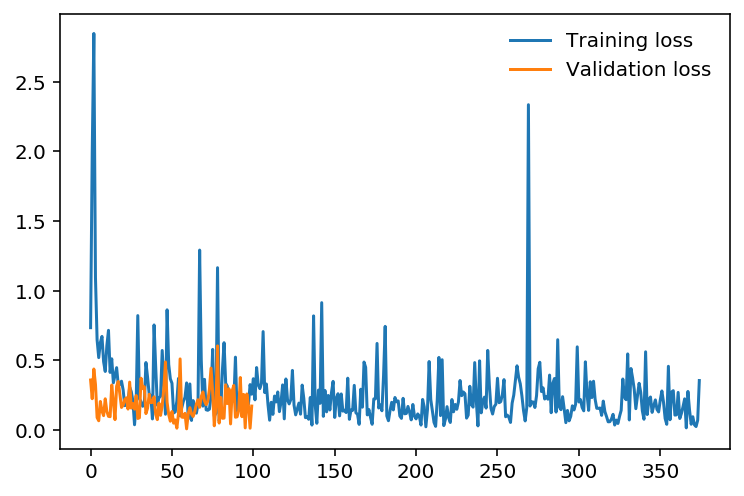

In [43]:
# plot the cost
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

### Load the Model with the Lowest Validation Loss

In [44]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## 5. Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [38]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
accuracy=0.0

model.eval() # prep model for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(inputs)
        # calculate the loss
        loss = criterion(output, labels)
        # update test loss 
        test_loss += loss.item()
        
        # Calculate accuracy
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        print(f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")

Test loss: 0.005.. Test accuracy: 0.333
Test loss: 0.006.. Test accuracy: 0.667
Test loss: 0.006.. Test accuracy: 1.000


 Play around with the hyperparameters (Learning rate, drop out, epochs) until you get the accuracy you need. 
 
 Thanks for stopping by.